In [1]:
# coding:utf-8
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets, linear_model

%matplotlib inline
sns.set_style({'font.sans-serif':['simhei','Arial']})
sns.set_style('white')

## 准备工作

* 分类器效果绘制

In [2]:
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.9)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

## NeuralNetwork实现
参考链接https://github.com/dennybritz/nn-from-scratch/blob/master/nn-from-scratch.ipynb

In [3]:
class NeuralNetwork(object):
    def __init__(self, 
                 nn_input_dim = 2, # 输入层节点
                 nn_output_dim = 2, # 输出层节点
                 nn_hide_dim = 3, # 隐藏层节点
                 lr = 0.01, # learning rate
                 reg_lambda = 0.01, # regularization strength
        ):
        self.nn_input_dim = nn_input_dim
        self.nn_output_dim = nn_output_dim
        self.nn_hide_dim = nn_hide_dim
        self.lr = lr
        self.reg_lambda = reg_lambda
        
        np.random.seed(0)
        self.W1 = np.random.randn(self.nn_input_dim, self.nn_hide_dim)
        self.b1 = np.zeros((1, self.nn_hide_dim))
        self.W2 = np.random.randn(self.nn_hide_dim, self.nn_output_dim)
        self.b2 = np.zeros((1, self.nn_output_dim))
    
    def _calc_proba(self, X):
        z1 = X.dot(self.W1) + self.b1
        # tanh
        a1 = np.tanh(z1)
        z2 = a1.dot(self.W2) + self.b2
        # softmax
        exp_scores = np.exp(z2)
        proba = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        
        self.z1 = z1
        self.a1 = a1
        self.z2 = z2
        return proba
    
    def fit(self, X, y, epoch=2000, vorbose=True):
        self.X = np.array(X)
        self.y = np.array(y)
        
        if self.X.shape[1] != self.nn_input_dim:
            raise Exception('X的维度与输入层节点数不同')
        if np.unique(self.y).shape[0] != self.nn_output_dim:
            raise Exception('y的维度与输出层节点数不同')
        if self.X.shape[0] != y.shape[0]:
            raise Exception('X与y的样本量不同')
            
        for i in range(epoch):
            # Forward propagation
            proba = self._calc_proba(self.X)
            
            # Back propagation (TODO zhanjiefan: 直接使用参考链接的代码，因为参考链接的公式与代码没法对上，后续优化)
            delta3 = proba
            delta3[range(self.y.shape[0]), y] -= 1
            dW2 = (self.a1.T).dot(delta3)
            db2 = np.sum(delta3, axis=0, keepdims=True)
            delta2 = delta3.dot(self.W2.T) * (1 - np.power(self.a1, 2))
            dW1 = np.dot(self.X.T, delta2)
            db1 = np.sum(delta2, axis=0)
            
            # 正则项
            dW1 += self.reg_lambda * self.W1
            dW2 += self.reg_lambda * self.W2
            
            # 梯度下降
            self.W1 -= self.lr * dW1
            self.b1 -= self.lr * db1
            self.W2 -= self.lr * dW2
            self.b2 -= self.lr * db2
        
    def predict(self, X_pred):
        proba = self._calc_proba(X_pred)
        return np.argmax(proba, axis=1)
    

In [4]:
# 测试神经网络 展示预测效果
def neural_network_test(X, y, hide_node_list,
                        nn_input_dim=2,
                        nn_output_dim=2,
                        epoch=2000
                       ):
    plot_row_num = (len(hide_node_list) - 1) // 3 + 1
    plt.figure(figsize=(15, plot_row_num * 4))
    for i, hide_node in enumerate(hide_node_list):
        plt.subplot(plot_row_num,3,i+1)
        if hide_node == 0:
            plt.title('input')
            plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.Spectral)
            continue
        plt.title('output\nNeural Network hidden node num: %d'%hide_node)
        nn = NeuralNetwork(nn_input_dim=nn_input_dim, nn_hide_dim=hide_node, nn_output_dim=nn_output_dim)
        nn.fit(X, y, epoch=epoch)
        plot_decision_boundary(lambda x: nn.predict(x))

## 二分类效果

In [5]:
np.random.seed(0)
X, y = datasets.make_moons(200, noise=0.20)

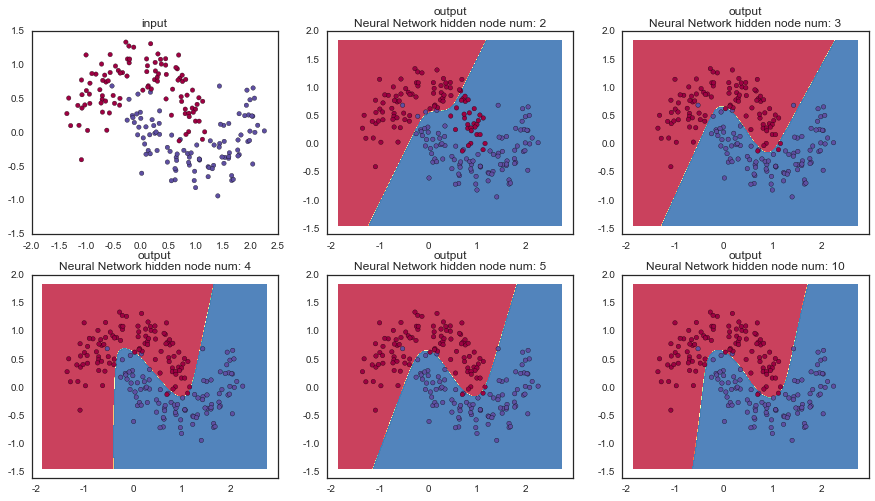

In [6]:
hide_node_list = [0,2,3,4,5,10]
neural_network_test(X, y, hide_node_list, nn_input_dim=2, nn_output_dim=2, epoch=200)

## 多分类效果

* 多分类数据集1

In [7]:
iris = datasets.load_iris()
X = iris.data[:, [1,3]]
y = iris.target

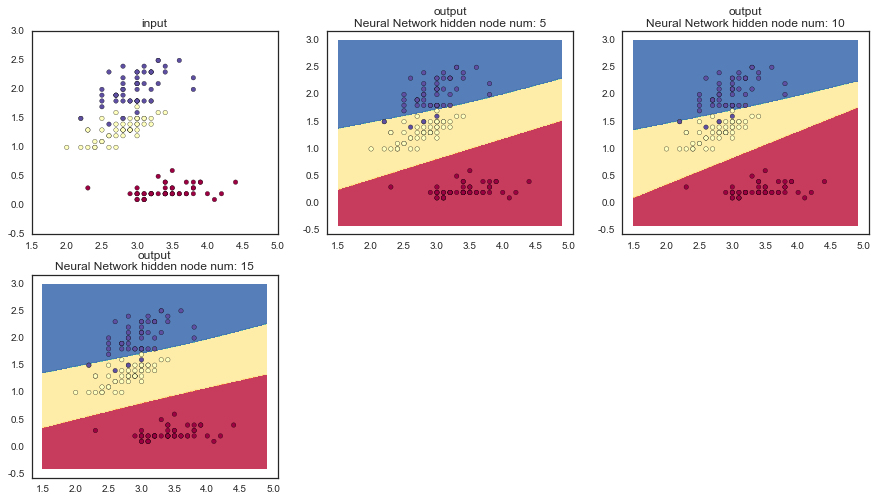

In [8]:
hide_node_list = [0,5,10,15]
neural_network_test(X, y, hide_node_list, nn_input_dim=2, nn_output_dim=3, epoch=20000)

* 多分类数据集2

In [9]:
center_nodes = [[1,1], [3,3], [4,1]]
data_size = 60
np.random.seed(0)
for i, center_node in enumerate(center_nodes):
    x1_center = center_node[0]
    x2_center = center_node[1]
    X_part = np.c_[
        np.random.randn(data_size).reshape(data_size, 1) + x1_center, 
        np.random.randn(data_size).reshape(data_size, 1) + x2_center,
    ]
    y_part = (np.ones((data_size, )) * i).astype(np.int)
    if i == 0:
        X = X_part
        y = y_part
    else:
        X = np.append(X, X_part, axis=0)
        y = np.append(y, y_part, axis=0)
# plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

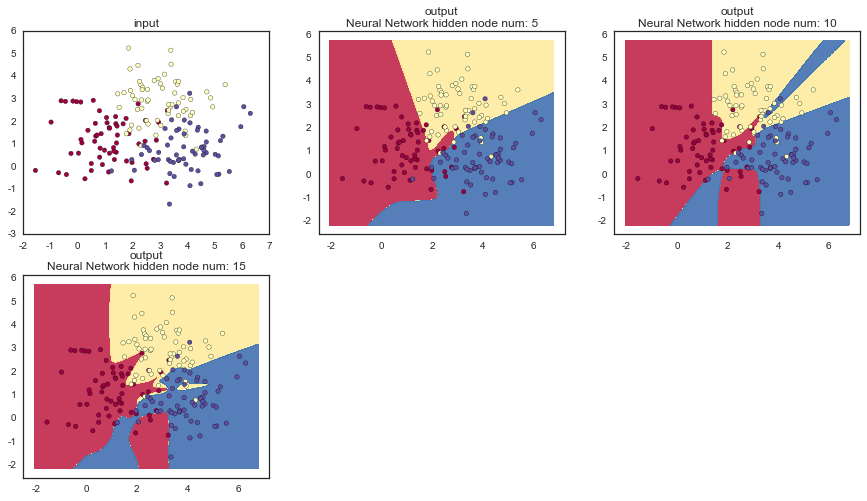

In [10]:
hide_node_list = [0,5,10,15]
neural_network_test(X, y, hide_node_list, nn_input_dim=2, nn_output_dim=3, epoch=20000)